In [2]:
from pathlib import Path
from topopt.monitoring import MetricTracker
import pandas as pd
import re

In [3]:
OUTPUTS_DIR = Path("../outputs")

metrics_by_run = {}

for run_dir in OUTPUTS_DIR.iterdir():
    if not run_dir.is_dir():
        continue

    metrics_path = run_dir / "metrics_log.npz"
    if not metrics_path.exists():
        continue

    name = run_dir.name
    if "neural_field" not in name:
        continue

    key = name.split("neural_field", 1)[1]
    key = key.lstrip("_-")

    # Load metrics
    metrics = MetricTracker.load(npz_path=metrics_path)

    metrics_by_run[key] = metrics

In [4]:
OUTPUTS_DIR = Path("../outputs")

def parse(path: Path) -> pd.DataFrame:
    return pd.read_csv(
        path,
        sep=",",
        index_col=0
    )


# ----------------------------------------
# Main aggregation
# ----------------------------------------

eval_results_by_run = {}

for run_dir in OUTPUTS_DIR.iterdir():
    if not run_dir.is_dir():
        continue

    log_path = run_dir / "model_evaluation.csv"
    if not log_path.exists():
        continue

    if "neural_field" not in run_dir.name:
        continue

    # Key: everything after "neural_field"
    key = run_dir.name.split("neural_field", 1)[1].lstrip("_-")

    try:
        df = parse(log_path)
    except Exception as e:
        print(f"[WARN] Failed to parse {log_path}: {e}")
        continue
    eval_results_by_run[key] = df

print(len(eval_results_by_run.keys()))

18


In [5]:
cols_to_drop = ["rho_actual", "rho_target", "rho_error", "penalty"]

for key, df in eval_results_by_run.items():
    # extract scale from key, e.g. "train_siren_omega_17_scale_2"
    match = re.search(r"scale_(\d+)", key)
    scale = int(match.group(1)) if match else None

    # add scale column
    df["scale"] = scale

    # drop unwanted columns (ignore in case some are missing)
    df.drop(columns=cols_to_drop, inplace=True, errors="ignore")

    print(key)
    print(df)


train_siren_omega_19_scale_3
         compliance  omega  scale
model                            
model_7     76.6803   19.0      3
model_6     77.1629   19.0      3
model_5     77.3159   19.0      3
model_1     78.1952   19.0      3
model_2     78.2871   19.0      3
model_4     78.3035   19.0      3
model_0     79.0783   19.0      3
model_3     82.6208   19.0      3
train_siren_omega_19_scale_1
         compliance  omega  scale
model                            
model_4     78.4334   19.0      1
model_1     78.9311   19.0      1
model_6     79.0345   19.0      1
model_5     79.2581   19.0      1
model_2     79.6815   19.0      1
model_7     80.6940   19.0      1
model_0     81.3774   19.0      1
model_3     82.8401   19.0      1
train_siren_omega_17_scale_3
         compliance  omega  scale
model                            
model_7     77.3287   17.0      3
model_6     77.7199   17.0      3
model_1     79.0396   17.0      3
model_2     79.5598   17.0      3
model_4     79.9983   17.0   

In [6]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

all_dfs = [df.copy() for df in eval_results_by_run.values()]
data = pd.concat(all_dfs, axis=0)

data["omega"] = pd.Categorical(
    data["omega"],
    categories=sorted(data["omega"].unique()),
    ordered=True
)

data = data[data["compliance"] < 90]

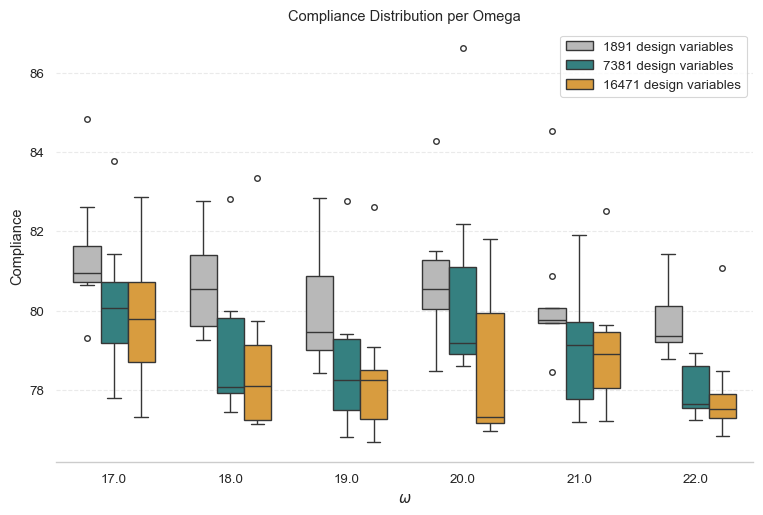

In [10]:

# --------------------------------------------------
# Seaborn style
# --------------------------------------------------
sns.set_theme(style="whitegrid", context="paper", font_scale=1.1)

# --------------------------------------------------
# Figure layout
# --------------------------------------------------
fig = plt.figure(figsize=(9, 9))
gs = fig.add_gridspec(2, 3, height_ratios=[2.2, 1])

# --------------------------------------------------
# (a) Boxplot
# --------------------------------------------------
ax_main = fig.add_subplot(gs[0, :])

palette = {
    1: "#b8b8b8",
    2: "#298c8c",
    3: "#f1a226",
}

sns.boxplot(
    data=data,
    x="omega",
    y="compliance",
    hue="scale",
    palette=palette,
    width=0.7,
    dodge=True,
    fliersize=4,
    linewidth=1,
    ax=ax_main
)

ax_main.set_xlabel(r"$\omega$")
ax_main.set_ylabel("Compliance")
ax_main.set_title("Compliance Distribution per Omega")

handles, labels = ax_main.get_legend_handles_labels()
labels = ["1891 design variables", "7381 design variables", "16471 design variables"]
ax_main.legend(handles, labels, frameon=True)

ax_main.grid(axis="y", linestyle="--", alpha=0.4)
sns.despine(ax=ax_main, left=True)

# from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# image_paths = {
    # 11:  "./omega_11.png",
    # 20: "./omega_20.png",
    # 35: "./omega_35.png",
# }

# y_top = ax_main.get_ylim()[1]

# img = plt.imread(image_paths[11])
# imagebox = OffsetImage(img, zoom=0.03)

# x_pos = 1.5
# y_pos = y_top * 0.89

# ab = AnnotationBbox(
    # imagebox,
    # (x_pos, y_pos),
    # frameon=True,
    # box_alignment=(0.5, 1.0)
# )

# ax_main.add_artist(ab)

plt.savefig(
    "complience_vs_omega_17-22.pdf",
    bbox_inches="tight"
)

In [8]:
all_dfs = []

for key, df in eval_results_by_run.items():
    tmp = df.copy()
    tmp["run_key"] = key   # keep filename / key
    all_dfs.append(tmp)

data = pd.concat(all_dfs, axis=0)

data["omega"] = pd.Categorical(
    data["omega"],
    categories=sorted(data["omega"].unique()),
    ordered=True
)

# apply your filter
data = data[data["compliance"] < 90]
data

,compliance,omega,scale,run_key
model,,,,
model_7,76.6803,19.0,3,train_siren_omega_19_scale_3
model_6,77.1629,19.0,3,train_siren_omega_19_scale_3
model_5,77.3159,19.0,3,train_siren_omega_19_scale_3
model_1,78.1952,19.0,3,train_siren_omega_19_scale_3
model_2,78.2871,19.0,3,train_siren_omega_19_scale_3
...,...,...,...,...
model_5,78.0735,18.0,2,train_siren_omega_18_scale_2
model_4,78.0786,18.0,2,train_siren_omega_18_scale_2
model_0,79.7616,18.0,2,train_siren_omega_18_scale_2


In [9]:
lowest_two = (data.nsmallest(3, "compliance"), [["compliance", "model", "run_key"]]
)

print(lowest_two)

(         compliance omega  scale                       run_key
model                                                         
model_7     76.6803  19.0      3  train_siren_omega_19_scale_3
model_7     76.8138  19.0      2  train_siren_omega_19_scale_2
model_6     76.8294  22.0      3  train_siren_omega_22_scale_3, [['compliance', 'model', 'run_key']])
